In [3]:
import sys
#sys.path.insert(0, "/home/llr/cms/cuisset/.local/lib/python3.11/site-packages") # for latest mplhep version
sys.path.insert(0, "/home/llr/cms/cuisset/.virtualenvs/modules-python-3.12-el9/lib/python3.12/site-packages")
import uproot
import awkward as ak
import numpy as np
import hist
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
from collections import defaultdict
from matplotlib.colors import LogNorm
import matplotlib
import uncertainties
from uncertainties import unumpy
import sys
import copy
import correctionlib, correctionlib.schemav2, correctionlib.convert

In [4]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def plot(h, ax):
    hep.hist2dplot(h, binwnorm=1., norm=LogNorm(), ax=ax)
    ax.set_ylabel("LHE HT (GeV)")
    ax.set_xlabel("Number of AK4 jets")
    ax.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    #ax.set_ylim(0, 500)

## backgrounds

In [5]:
# all bkgs
# h_btag = uproot.open("/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_2018_ZZ_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_withbTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_zz_sig_vs_bkg__nodata__stack.root:histograms/all_background").to_hist()
# h_nobtag = uproot.open("/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_2018_ZZ_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_nobTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_zz_sig_vs_bkg__nodata__stack.root:histograms/all_background").to_hist()
year = "2016_HIPM"
year = str(year)
def load(process):
    pattern = "/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_{year}_ZZ_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D{btag_suffix}/root/nJet_LHE_HT_variableBinning__baseline_region__pg_zz__nodata__stack.root:histograms/{process}"
    if process == "others": # "zz": ["zz_sl_signal","higgs","vv_v","wjets","dy","others","tt","ttx","data",]
        process_list = ["higgs", "vv_v", "others", "ttx"]
    else:
        process_list = [process]
    h_btag_list = [uproot.open(pattern.format(year=year, btag_suffix="_withbTagWeight", process=split_proc)).to_hist() for split_proc in process_list]
    h_nobtag_list = [uproot.open(pattern.format(year=year, btag_suffix="_nobTagWeight", process=split_proc)).to_hist() for split_proc in process_list]
    return sum(h_nobtag_list), sum(h_btag_list)
all_bkg_processes = ["tt", "dy", "wjets", "others"]
hs_perProcess = {process : load(process) for process in all_bkg_processes}


Text(0.5, 1.0, 'Without btag reshaping weights')

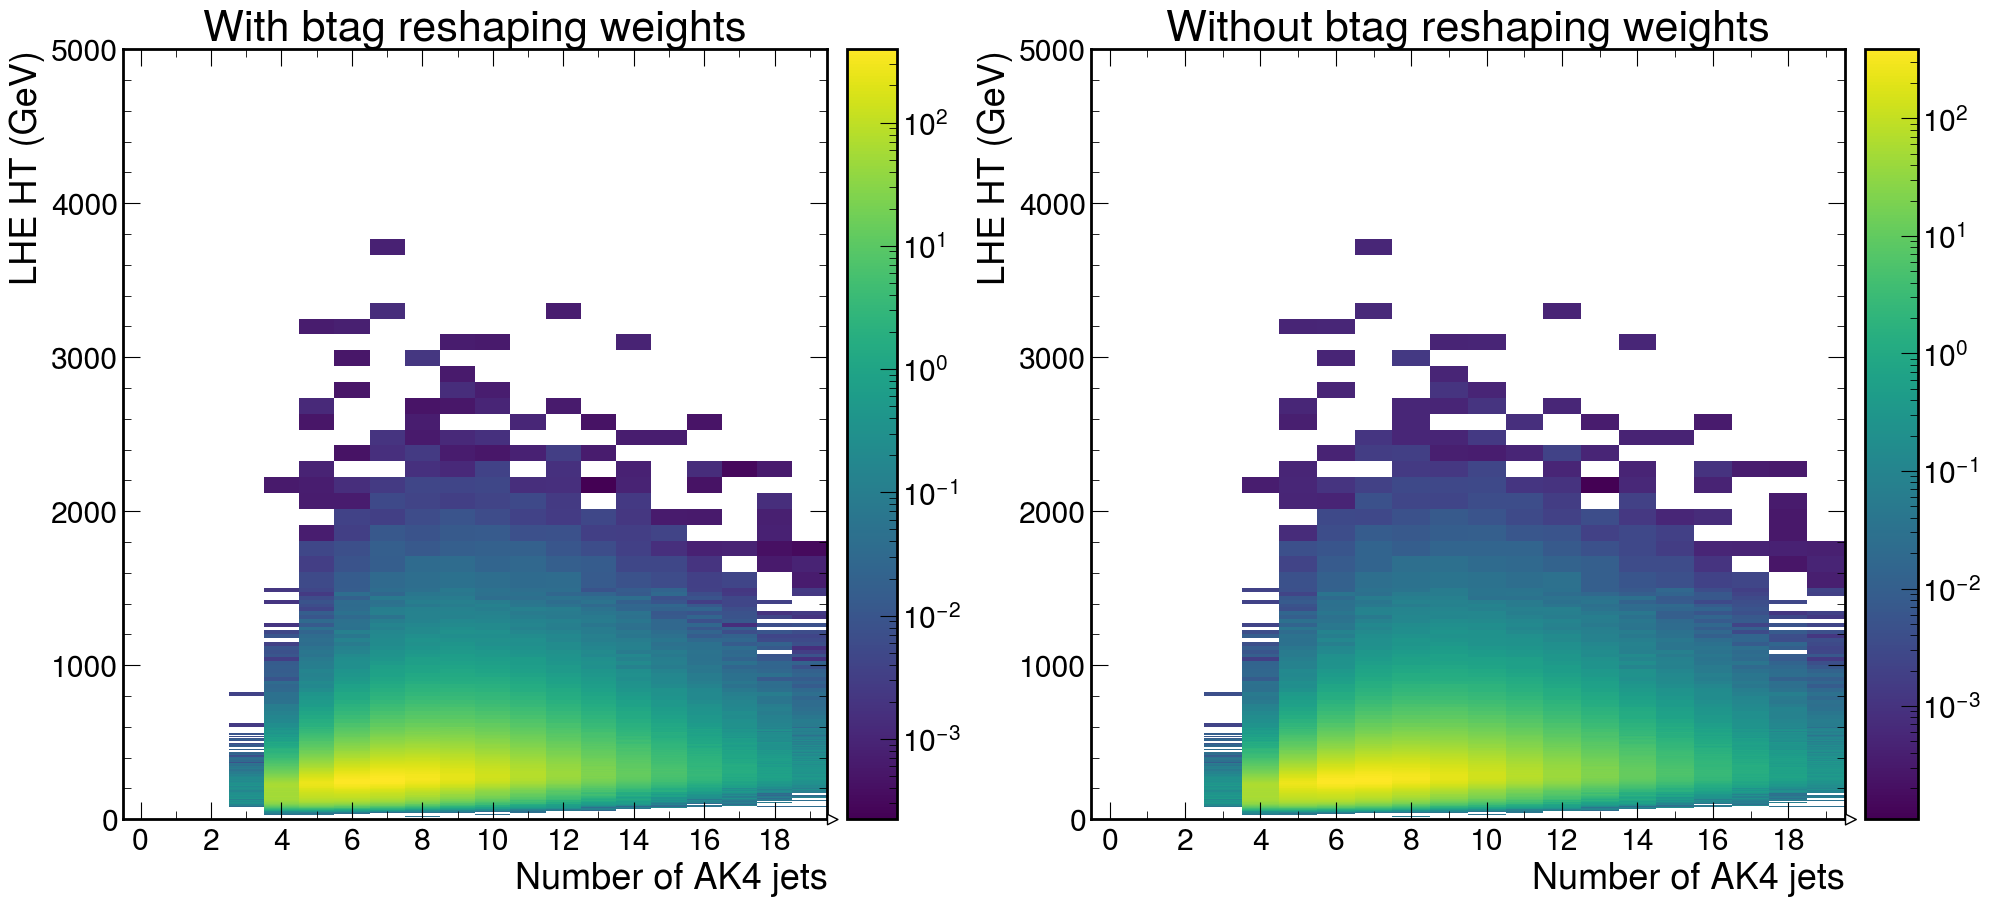

In [6]:
process = "tt"
fig, (ax_btag, ax_nobtag) = plt.subplots(1, 2, figsize=(20, 10))
plot(hs_perProcess[process][1], ax_btag)
plt.title("With btag reshaping weights")
plot(hs_perProcess[process][0], ax_nobtag)
plt.title("Without btag reshaping weights")

In [68]:
hs_perProcess["wjets"][0].axes[1].edges[200:]

array([ 200.        ,  205.        ,  210.        ,  215.        ,
        220.        ,  225.        ,  230.        ,  235.        ,
        240.        ,  245.        ,  250.        ,  255.        ,
        260.        ,  265.        ,  270.        ,  275.        ,
        280.        ,  285.        ,  290.        ,  295.        ,
        300.        ,  305.        ,  310.        ,  315.        ,
        320.        ,  325.        ,  330.        ,  335.        ,
        340.        ,  345.        ,  350.        ,  355.        ,
        360.        ,  365.        ,  370.        ,  375.        ,
        380.        ,  385.        ,  390.        ,  395.        ,
        400.        ,  405.        ,  410.        ,  415.        ,
        420.        ,  425.        ,  430.        ,  435.        ,
        440.        ,  445.        ,  450.        ,  455.        ,
        460.        ,  465.        ,  470.        ,  475.        ,
        480.        ,  485.        ,  490.        ,  495.     

In [7]:

def make_extrap_factor(h_nobtag, h_btag, rebin_x=hist.rebin(1), rebin_y=hist.rebin(1), flow=True):
    h_nobtag_rebin = h_nobtag[::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)]
    h_btag_rebin = h_btag[::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)]
    extrap_factor = unumpy.uarray(h_nobtag_rebin.values(flow=flow), np.sqrt(h_nobtag_rebin.variances(flow=flow)))/(unumpy.uarray(h_btag_rebin.values(flow=flow)+sys.float_info.epsilon, np.sqrt(h_btag_rebin.variances(flow=flow))))
    negative_values = (h_btag_rebin.values(flow=flow) <= 0.)|(h_nobtag_rebin.values(flow=flow) <= 0.)
    return np.where(negative_values, np.ones_like(h_nobtag_rebin.values(flow=flow)), unumpy.nominal_values(extrap_factor)), np.where(negative_values, np.zeros_like(h_nobtag_rebin.values(flow=flow)), np.square(unumpy.std_devs(extrap_factor))) 
def make_extrap_factor_hist(h_nobtag, h_btag, values, variances, rebin_x=hist.rebin(1), rebin_y=hist.rebin(1), flow=True): # make the extrap factor hist from the factors array
    h_nobtag_rebin = h_nobtag[::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)]
    h_extrap_factor = hist.Hist(*h_nobtag_rebin.axes, storage="weight")
    h_extrap_factor.view(flow).value = values
    h_extrap_factor.view(flow).variance = variances
    return h_extrap_factor
def get_rebin_bkg(process, h_nobtag):
    if process == "tt":
        rebin_x, rebin_y, flow = hist.rebin(edges=[0, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20]), hist.rebin(
            edges=[0, 50] + list(np.arange(100, 500, 50)) + list(np.arange(500, 1000, 50)) + [1000, 1200, 1500, find_nearest(h_nobtag.axes[1].edges, 2000), 5000]), True
    elif process == "dy":
        rebin_x, rebin_y, flow = hist.rebin(edges=[0, 5, 6, 7, 8, 9, 10, 11, 12] + ([14, 16, 18, 20] if "2016" in year  else [15, 20])), hist.rebin(
            edges=[0, 40, 60] + list(np.arange(60, 200, 20)) + list(np.arange(200, 400, 50)) + list(np.arange(400, 1000, 100)) + [1000, find_nearest(h_nobtag.axes[1].edges, 1500), 5000]), True
    elif process == "wjets":
        rebin_x, rebin_y, flow = hist.rebin(edges=[0, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16] + ([18, 20] if year in ["2017", "2018"] else [20])), hist.rebin(
            edges=[0, 5, 20, 50, 75] + list(np.arange(100, 500, 50)) + list(np.arange(500, 1000, 50)) + list(np.arange(1000, 1500, 200)) + [1500, find_nearest(h_nobtag.axes[1].edges, 1700), find_nearest(h_nobtag.axes[1].edges, 2000), find_nearest(h_nobtag.axes[1].edges, 2300), find_nearest(h_nobtag.axes[1].edges, 2700), find_nearest(h_nobtag.axes[1].edges, 3500), 5000]), True
    elif process == "others":
        rebin_x, rebin_y, flow = hist.rebin(edges=[0, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16] + ([18, 20] if year in ["2017", "2018"] else [20])), hist.rebin(
            edges=[0, 20] + list(np.arange(20, 100, 20)) + list(np.arange(100, 500, 50)) + list(np.arange(500, 800, 50)) + [800, 1200, find_nearest(h_nobtag.axes[1].edges, 1700), 5000]), True
    else:
        rebin_x, rebin_y, flow = hist.rebin(edges=[0, 5, 6, 7, 8, 9, 10, 11, 12, 14, 16, 18, 20]), hist.rebin(
            edges=[0, 20] + list(np.arange(20, 100, 20)) + list(np.arange(100, 500, 50)) + list(np.arange(500, 1000, 50)) + list(np.arange(1000, 1500, 200)) + [1500, find_nearest(h_nobtag.axes[1].edges, 2000), find_nearest(h_nobtag.axes[1].edges, 2500), find_nearest(h_nobtag.axes[1].edges, 3500), 5000]), True
    return rebin_x, rebin_y
def make_factor_full(h_nobtag, h_btag, process=None):
    rebin_x, rebin_y = get_rebin_bkg(process, h_nobtag)
    flow = True
    return make_extrap_factor_hist(h_nobtag, h_btag, *make_extrap_factor(h_nobtag, h_btag, rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
    #h_extrap_factor_bkg = h_extrap_factor

/tmp/ipykernel_1072015/2202804038.py:52: RuntimeWarning: invalid value encountered in scalar divide
  f'{h_extrap_factor[bin0, bin1].value:.2f}\n({np.square(h_nobtag_rebinned[bin0, bin1].value)/h_nobtag_rebinned[bin0, bin1].variance:.1f})',


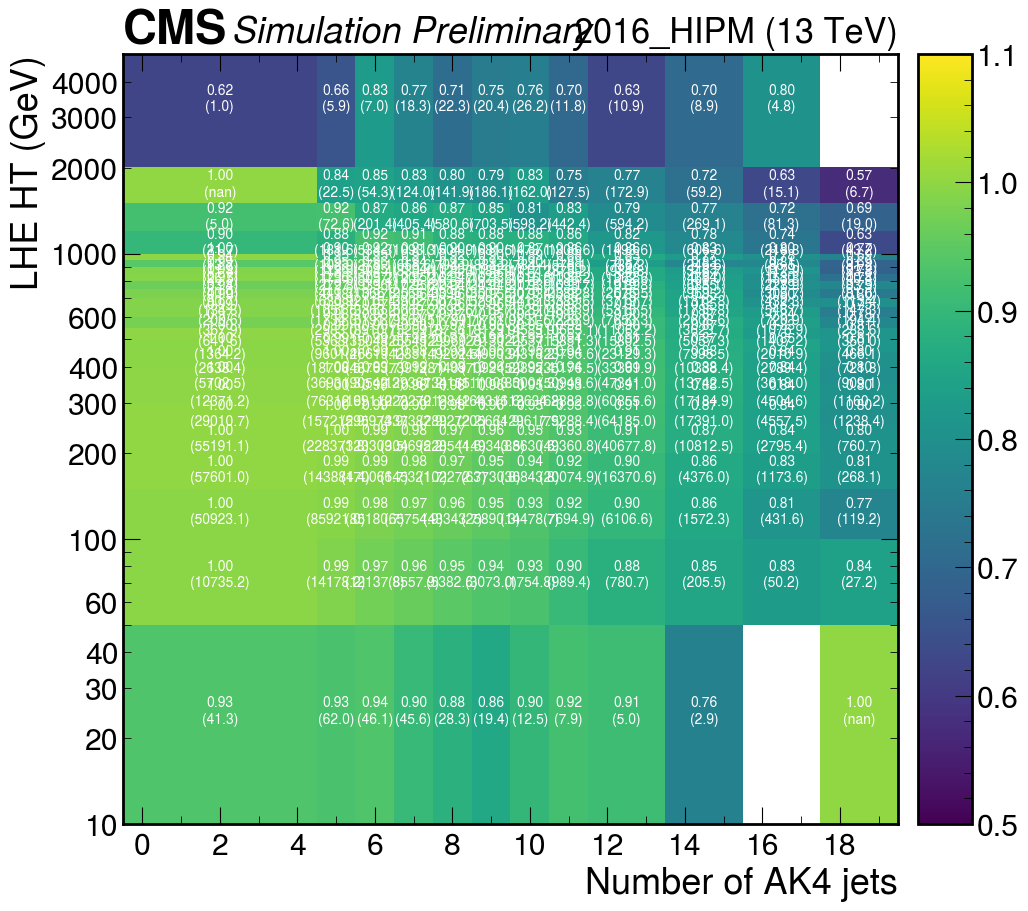

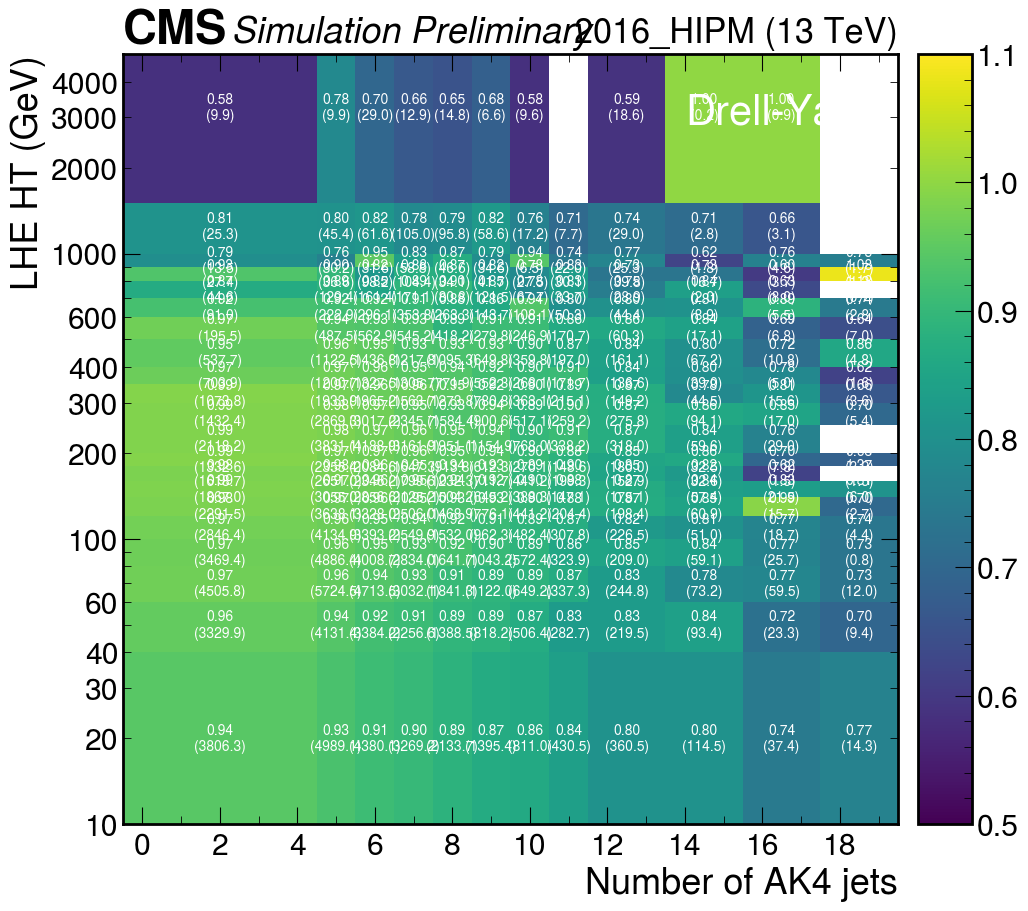

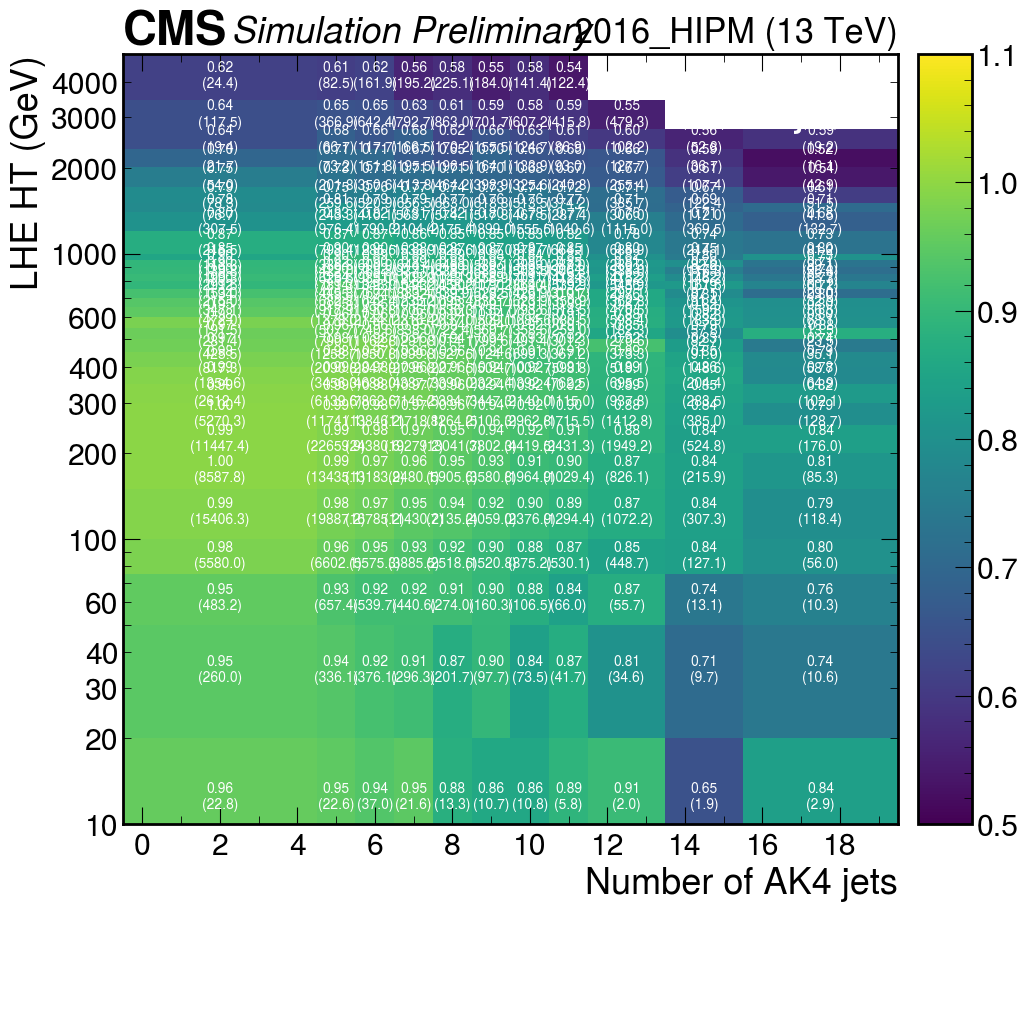

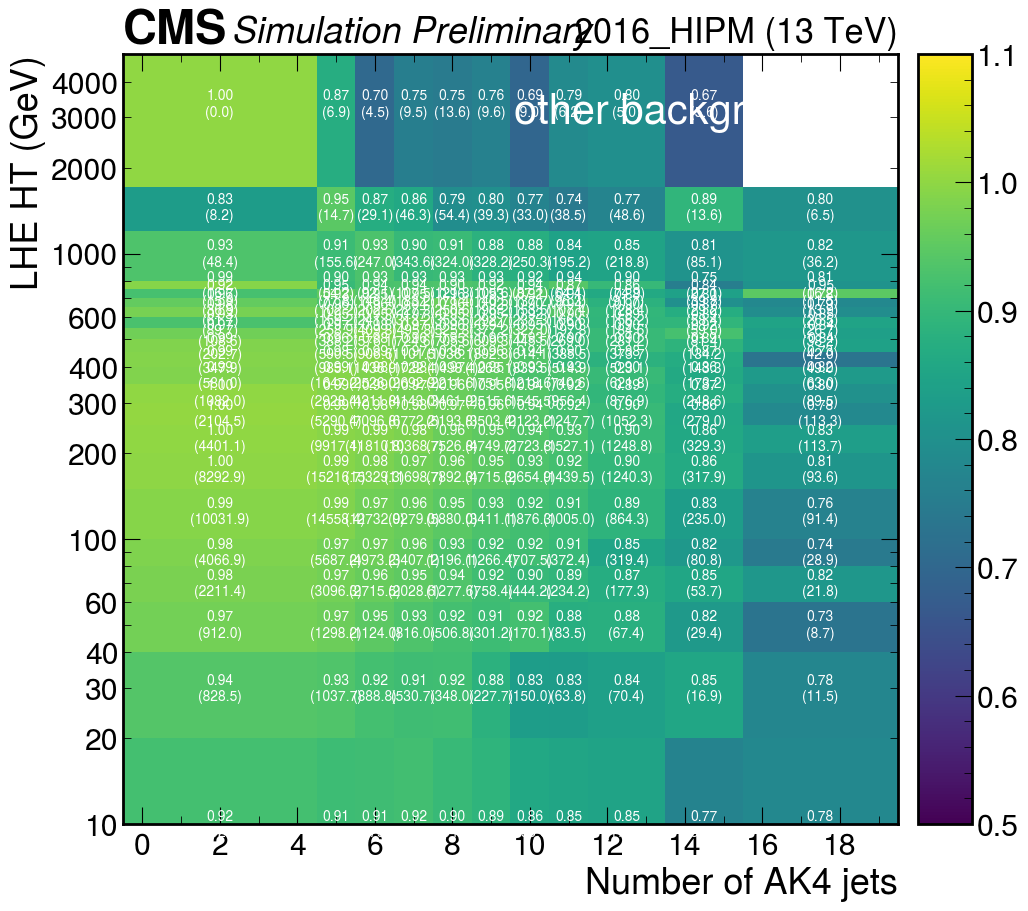

In [9]:
text=True
log = True
kwargs = dict(cmin=0.5, cmax=1.1, flow=None)
#kwargs = dict(flow=None)
process_legend = dict(tt=r"$t\bar{t}$", dy="Drell-Yan", wjets="W+jets", others="other backgrounds")

h_extrap_factors_bkgs = {}
for process in all_bkg_processes: #["tt"]:#all_bkg_processes:

    #kwargs = dict()
    h_extrap_factor = make_factor_full(*hs_perProcess[process], process=process)
    rebin_x, rebin_y = get_rebin_bkg(process, hs_perProcess[process][0])
    h_nobtag_rebinned = hs_perProcess[process][0][::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)]
    h_extrap_factors_bkgs[process] = h_extrap_factor
    if log:
        fig, (ax1) = plt.subplots()
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    ax1.set_ylabel("LHE HT (GeV)")
    ax1.set_xlabel("Number of AK4 jets")
    hep.hist2dplot(h_extrap_factor, ax=ax1, **kwargs)
    ax1.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
    ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    # plt.yscale("log")
    if log:
        ax1.set_ylim(10, 5000)
        ax1.set_yscale("log")
        #ax1.set_yticks([10, 20, 50, 100, 200, 500, 1000, 1500, 2000, 3000, 5000])
        f = matplotlib.ticker.ScalarFormatter()
        f.set_scientific(False)
        ax1.yaxis.set_major_formatter(f)
        ax1.yaxis.set_minor_formatter(matplotlib.ticker.LogFormatter(minor_thresholds=(10, 0.4)))
        hep.cms.label(year=year, data=False, label="Preliminary")
        ax1.text(0.95, 0.95, process_legend.get(process, process), transform=ax1.transAxes, ha="right", va="top", color="white", fontsize=30)
    else:
        fig.suptitle("b-tag extrapolation factors for " + process_legend.get(process, process),)

    # uncert_mode = "MCcount"
    # h_rebin = hs_perProcess[process][0][::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)]
    # def make_uncert(bin0, bin1):
    #     if uncert_mode == "propag":
    #         return f'\n±{np.sqrt(h_extrap_factor[bin0, bin1].variance):.3f}'
    #     elif uncert_mode == "MCcount":
    #         return False # print(np.square(v.value)/v.variance)
        
    if text:
        for bin0 in range(len(h_extrap_factor.axes[0])):
            for bin1 in range(len(h_extrap_factor.axes[1])):
                ax1.text(h_extrap_factor.axes[0].centers[bin0], 
                        h_extrap_factor.axes[1].centers[bin1], 
                        #f'{h_extrap_factor[bin0, bin1].value:.2f}\n±{np.sqrt(h_extrap_factor[bin0, bin1].variance):.3f}', 
                        f'{h_extrap_factor[bin0, bin1].value:.2f}\n({np.square(h_nobtag_rebinned[bin0, bin1].value)/h_nobtag_rebinned[bin0, bin1].variance:.1f})',
                        color='white', ha='center', va='center', fontsize=10)
    if not log:
        hep.hist2dplot(h_extrap_factor, ax=ax2, **kwargs)
        ax2.set_ylabel("LHE HT (GeV)")
        ax2.set_xlabel("Number of AK4 jets")
        ax2.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
        ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
        ax2.set_ylim(0, 300)

        if text:
            for bin0 in range(len(h_extrap_factor.axes[0])):
                for bin1 in range(len(h_extrap_factor.axes[1])):
                    ax2.text(h_extrap_factor.axes[0].centers[bin0], 
                            h_extrap_factor.axes[1].centers[bin1], 
                            #f'{h_extrap_factor[bin0, bin1].value:.2f}\n±{np.sqrt(h_extrap_factor[bin0, bin1].variance):.3f}', 
                            f'{h_extrap_factor[bin0, bin1].value:.2f}\n({np.square(h_nobtag_rebinned[bin0, bin1].value)/h_nobtag_rebinned[bin0, bin1].variance:.1f})',
                            color='white', ha='center', va='center', fontsize=10)
    #plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/{process}{'_log' if log else ''}_{year}.pdf", bbox_inches="tight")

## signals

In [71]:
resonant_masses_ZZ = [ 200, 210, 220, 230, 240, 250, 260, 270, 280, 300, 320, 350, 360, 400, 450, 500, 550,
                600, 650, 700, 750, 800, 850, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700,
                1800, 1900, 2000, 2200, 2400, 2500, 2600, 2800, 3000, 3500, 4000, 4500, 5000]
with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_{year}_ZZ_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_signal_withbTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_all_signals__nodata__stack.root:histograms") as d:
    h_btag_zz_signal = {mass:d[f"ggXZZbbtt_M{mass}"].to_hist() for mass in resonant_masses_ZZ}
    h_btag_zz_signal[0] = d["zz_sl_signal"].to_hist()
with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_{year}_ZZ_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_signal_nobTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_all_signals__nodata__stack.root:histograms") as d:
    h_nobtag_zz_signal = {mass:d[f"ggXZZbbtt_M{mass}"].to_hist() for mass in resonant_masses_ZZ}
    h_nobtag_zz_signal[0] = d["zz_sl_signal"].to_hist()

In [72]:
resonant_masses_ZH = [500,600,700,800,1000,1200,1400,1600,1800,2000,2500,3000,3500,4000,4500,5000,5500,6000]
with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_{year}_ZbbHtt_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_signal_withbTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_all_signals__nodata__stack.root:histograms") as d:
    h_btag_zbbhtt_signal = {mass:d[f"Zprime_Zh_Zbbhtautau_M{mass}"].to_hist() for mass in resonant_masses_ZH}
    h_btag_zbbhtt_signal[0] = d["zh_zbb_htt_signal"].to_hist()
    h_btag_ztthbb_signal = {mass:d[f"Zprime_Zh_Ztautauhbb_M{mass}"].to_hist() for mass in resonant_masses_ZH}
    h_btag_ztthbb_signal[0] = d["zh_ztt_hbb_signal"].to_hist()
with uproot.open(f"/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot2D/bul_{year}_ZbbHtt_v12/cat_baseline_resolved_nobtag/prod_250315_btag_extrap_factor_2D_signal_nobTagWeight/root/nJet_LHE_HT_variableBinning__baseline_region__pg_all_signals__nodata__stack.root:histograms") as d:
    h_nobtag_zbbhtt_signal = {mass:d[f"Zprime_Zh_Zbbhtautau_M{mass}"].to_hist() for mass in resonant_masses_ZH}
    h_nobtag_zbbhtt_signal[0] = d["zh_zbb_htt_signal"].to_hist()
    h_nobtag_ztthbb_signal = {mass:d[f"Zprime_Zh_Ztautauhbb_M{mass}"].to_hist() for mass in resonant_masses_ZH}
    h_nobtag_ztthbb_signal[0] = d["zh_ztt_hbb_signal"].to_hist()

In [73]:
h_model = h_nobtag_zz_signal[0] # to get the binning
ht_axis = h_model.axes[1]

In [74]:
# h_btag_res_sum = sum(h_btag_res.values())
# h_nobtag_res_sum = sum(h_nobtag_res.values())

In [75]:
def plot_factors(h_extrap_factor, h_rebinned=None, text=False, ylim_intermediate=500):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))
    hep.hist2dplot(h_extrap_factor, ax=ax1)
    ax1.set_ylabel("LHE HT (GeV)")
    ax1.set_xlabel("Number of AK4 jets")
    ax1.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
    ax1.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    # plt.yscale("log")
    plt.title("b-tag extrapolation factors for signal")
    ax1.set_ylim(0, 5000)

    uncert_mode = "MCcount"
    def make_uncert(bin0, bin1):
        if uncert_mode == "propag":
            return f'\n±{np.sqrt(h_extrap_factor[bin0, bin1].variance):.3f}'
        elif uncert_mode == "MCcount":
            v = h_rebinned[bin0, bin1]
            return f'\n({np.square(v.value)/v.variance:.1f})' 

    if text:
        for bin0 in range(len(h_extrap_factor.axes[0])):
            for bin1 in range(len(h_extrap_factor.axes[1])):
                ax1.text(h_extrap_factor.axes[0].centers[bin0], 
                        h_extrap_factor.axes[1].centers[bin1], 
                        f'{h_extrap_factor[bin0, bin1].value:.3f}{make_uncert(bin0, bin1)}', 
                        color='white', ha='center', va='center', fontsize=15)

    hep.hist2dplot(h_extrap_factor, ax=ax2)
    ax2.set_ylabel("LHE HT (GeV)")
    ax2.set_xlabel("Number of AK4 jets")
    ax2.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
    ax2.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    ax2.set_ylim(0, ylim_intermediate)

    if text:
        for bin0 in range(len(h_extrap_factor.axes[0])):
            for bin1 in range(len(h_extrap_factor.axes[1])):
                ax2.text(h_extrap_factor.axes[0].centers[bin0], 
                        h_extrap_factor.axes[1].centers[bin1], 
                        f'{h_extrap_factor[bin0, bin1].value:.3f}{make_uncert(bin0, bin1)}', 
                        color='white', ha='center', va='center', fontsize=10, clip_on=True)

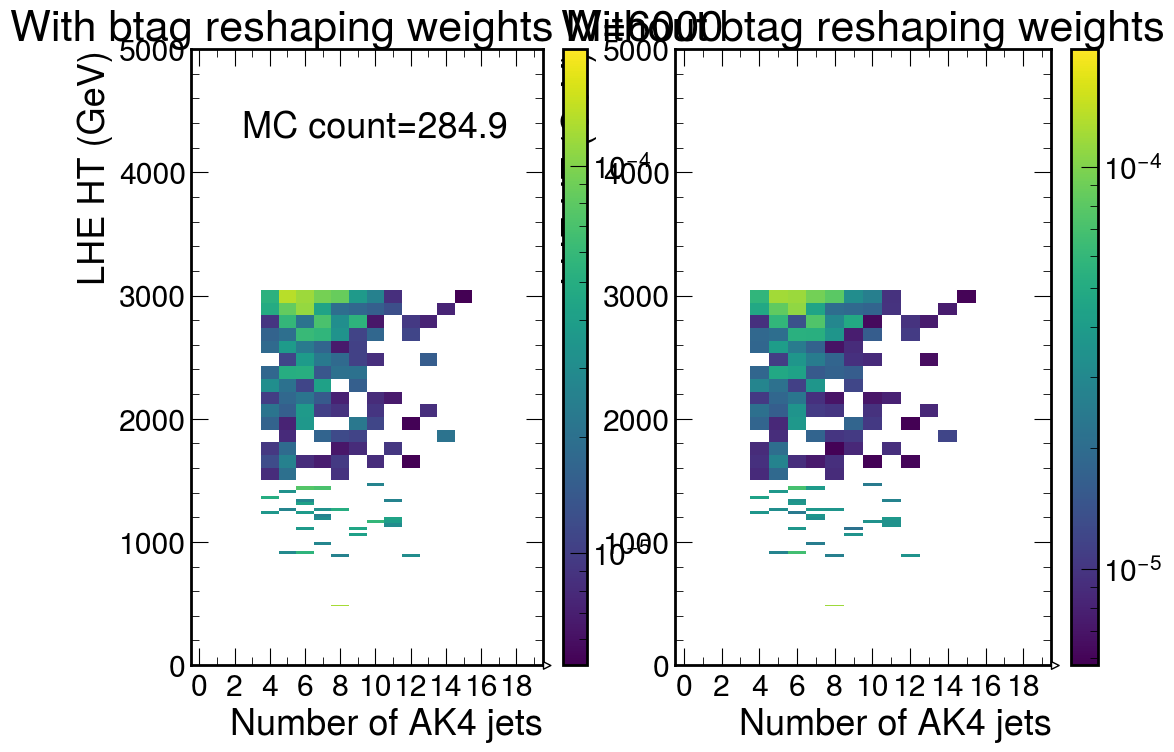

In [76]:
h_btag, h_nobtag = h_btag_ztthbb_signal, h_nobtag_ztthbb_signal
h_btag, h_nobtag = h_btag_zbbhtt_signal, h_nobtag_zbbhtt_signal
for mass in [6000]:
    fig, (ax_btag, ax_nobtag) = plt.subplots(1, 2, figsize=(10, 8))
    plot(h_btag[mass], ax_btag)
    if mass < 500: ax_btag.set_ylim(top=500)
    elif mass < 1000: ax_btag.set_ylim(top=1000)
    elif mass < 2000: ax_btag.set_ylim(top=2000)
    elif mass < 3000: ax_btag.set_ylim(top=2500)
    ax_btag.text(0.9, 0.9, f"MC count={np.square(h_btag_zbbhtt_signal[mass].sum().value)/h_btag_zbbhtt_signal[mass].sum().variance:.1f}", transform=ax_btag.transAxes, ha="right", va="top")
    plt.title(f"With btag reshaping weights M={mass}")
    plot(h_nobtag[mass], ax_nobtag)
    plt.title("Without btag reshaping weights")

In [77]:
def get_rebin_signal_ztthbb(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 5, 7, 12, 20]), hist.rebin(edges=[0, 10, 20, 40, 70, 100, 170, 300, 450, 600, 5000])
    if mass ==500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 300, 5000])
    if mass ==600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 180, 250, 320, 5000])
    if mass ==700:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 230, 290, 340, 400, 5000])
    if mass ==800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 250, 320, 450, 5000])
    if mass ==1000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 300, 400, 550, 5000])
    if mass ==1200:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 350, 500, 700, 5000])
    if mass ==1400:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 550, 750, 5000])
    if mass ==1600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 450, 700, 900, 5000])
    if mass ==1800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 500, 750, 1100, 5000])
    if mass ==2500:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 700, 1000, 1500, 5000])
    if mass ==3000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 900, 1300, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==3500:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1000, 1500, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==4000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1500, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2500), 5000])
    if mass <=5000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2300), find_nearest(ht_axis.edges, 3000), 5000])
    if mass <=6000:
        return hist.rebin(edges=[0, 6, 8, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 2800), 5000])
    #return get_rebin_signal_zz(mass)
    raise ValueError(mass)
def get_rebin_signal_zbbhtt(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 5, 7, 12, 20]), hist.rebin(edges=[0, 90, 130, 160, 200, 300, 400, 600, 5000])
    if mass ==500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 250, 5000])
    if mass ==600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 180, 250, 290, 5000])
    if mass ==700:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 200, 270, 320, 350, 5000])
    if mass ==800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 250, 320, 450, 5000])
    if mass ==1000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 300, 400, 550, 5000])
    if mass ==1200:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 350, 500, 700, 5000])
    if mass ==1400:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 550, 750, 5000])
    if mass ==1600:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 450, 650, 800, 5000])
    if mass ==1800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 500, 750, 1000, 5000])
    if mass ==2500:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 700, 1000, 1500, 5000])
    if mass ==3000:
        return hist.rebin(edges=[0, 6, 10, 20]), hist.rebin(edges=[0, 900, 1300, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==3500:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1000, 1500, find_nearest(ht_axis.edges, 2000), 5000])
    if mass ==4000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, 1500, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2500), 5000])
    if mass <=5000:
        return hist.rebin(edges=[0, 6, 9, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 1800), find_nearest(ht_axis.edges, 2300), find_nearest(ht_axis.edges, 3000), 5000])
    if mass <=6000:
        return hist.rebin(edges=[0, 6, 8, 20]), hist.rebin(edges=[0, find_nearest(ht_axis.edges, 2600), 5000])
    #return get_rebin_signal_zz(mass)
    raise ValueError(mass)

def get_rebin_signal_zz(mass):
    if mass == 0: # SM signal
        return hist.rebin(edges=[0, 7, 10, 20]), hist.rebin(edges=[0, 100, 200, 300, 500,5000])
    if mass < 300:
        return hist.rebin(edges=[0, 7, 9, 11, 20]), hist.rebin(edges=[0, 80, 130, 200, 300, 5000])
    elif mass <= 500:
        return hist.rebin(edges=[0, 7, 10, 13, 20]), hist.rebin(edges=[0, 120, 180, 250, 300, 400, 5000])
    elif mass <= 800:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 150, 200, 300, 350, 400, 450, 500, 600, 5000])
    elif mass <= 1500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 200, 300, 400, 500, 600, 800, 5000])
    elif mass <= 2500:
        return hist.rebin(edges=[0, 6, 8, 10, 12, 20]), hist.rebin(edges=[0, 250, 400, 600, 800, 1000, 1200, 5000])
    elif mass <= 3500:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 400, 700, 1000, 1300, find_nearest(ht_axis.edges, 1700), 5000])
    elif mass <= 5000:
        return hist.rebin(edges=[0, 6, 8, 12, 20]), hist.rebin(edges=[0, 1000, find_nearest(ht_axis.edges, 1700), find_nearest(ht_axis.edges, 2500), 5000])


/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'
/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'
/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'
/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'


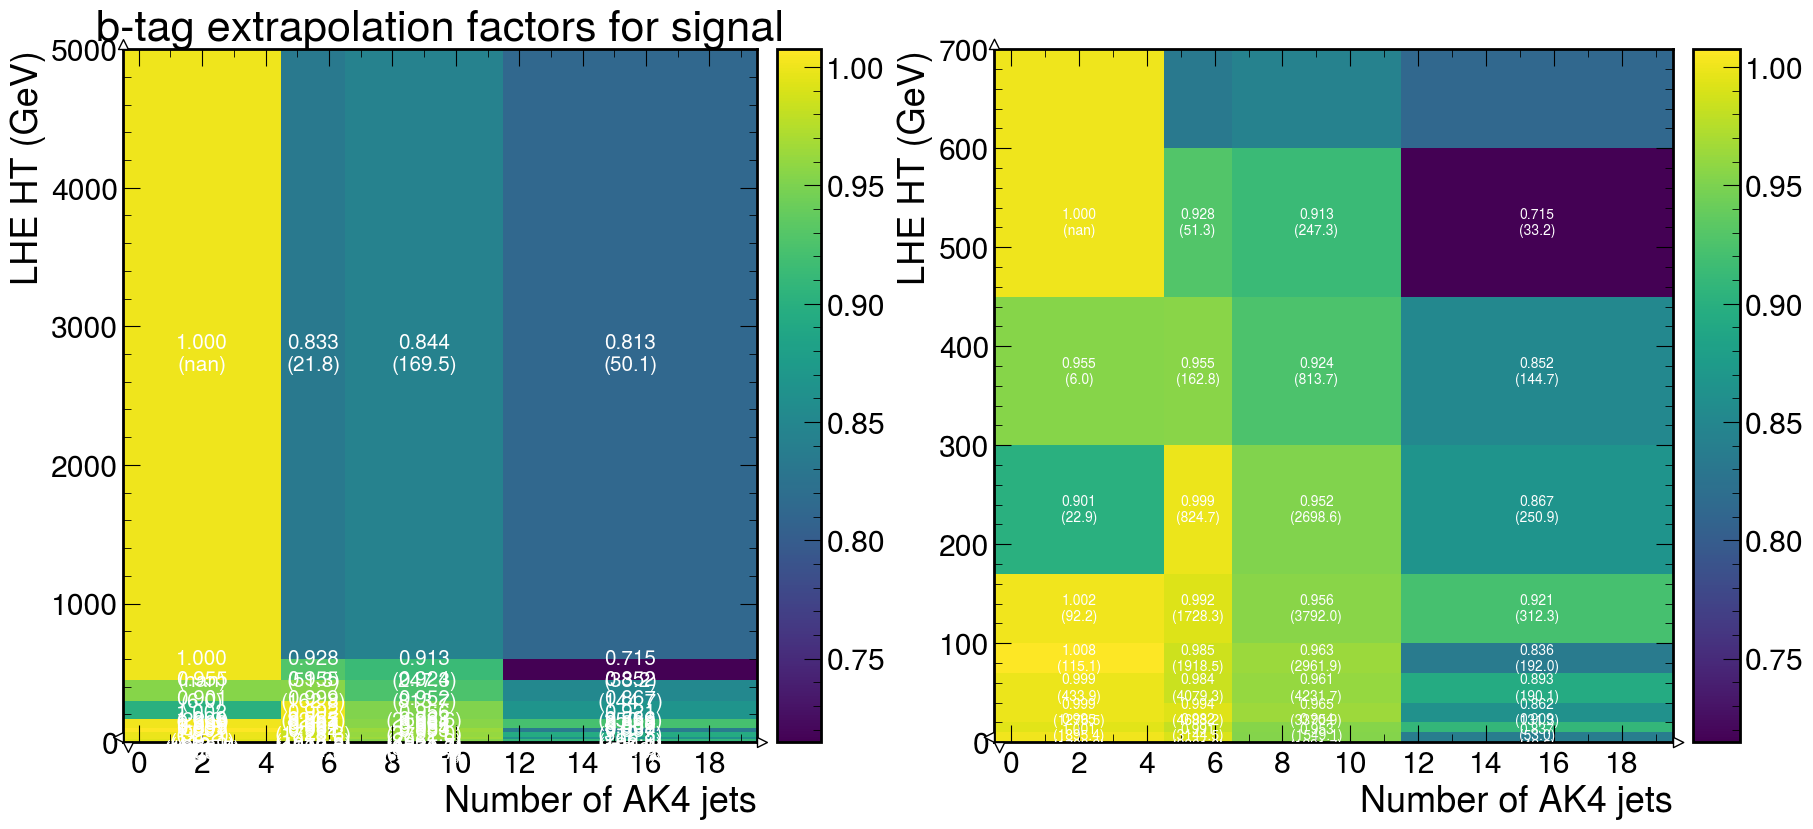

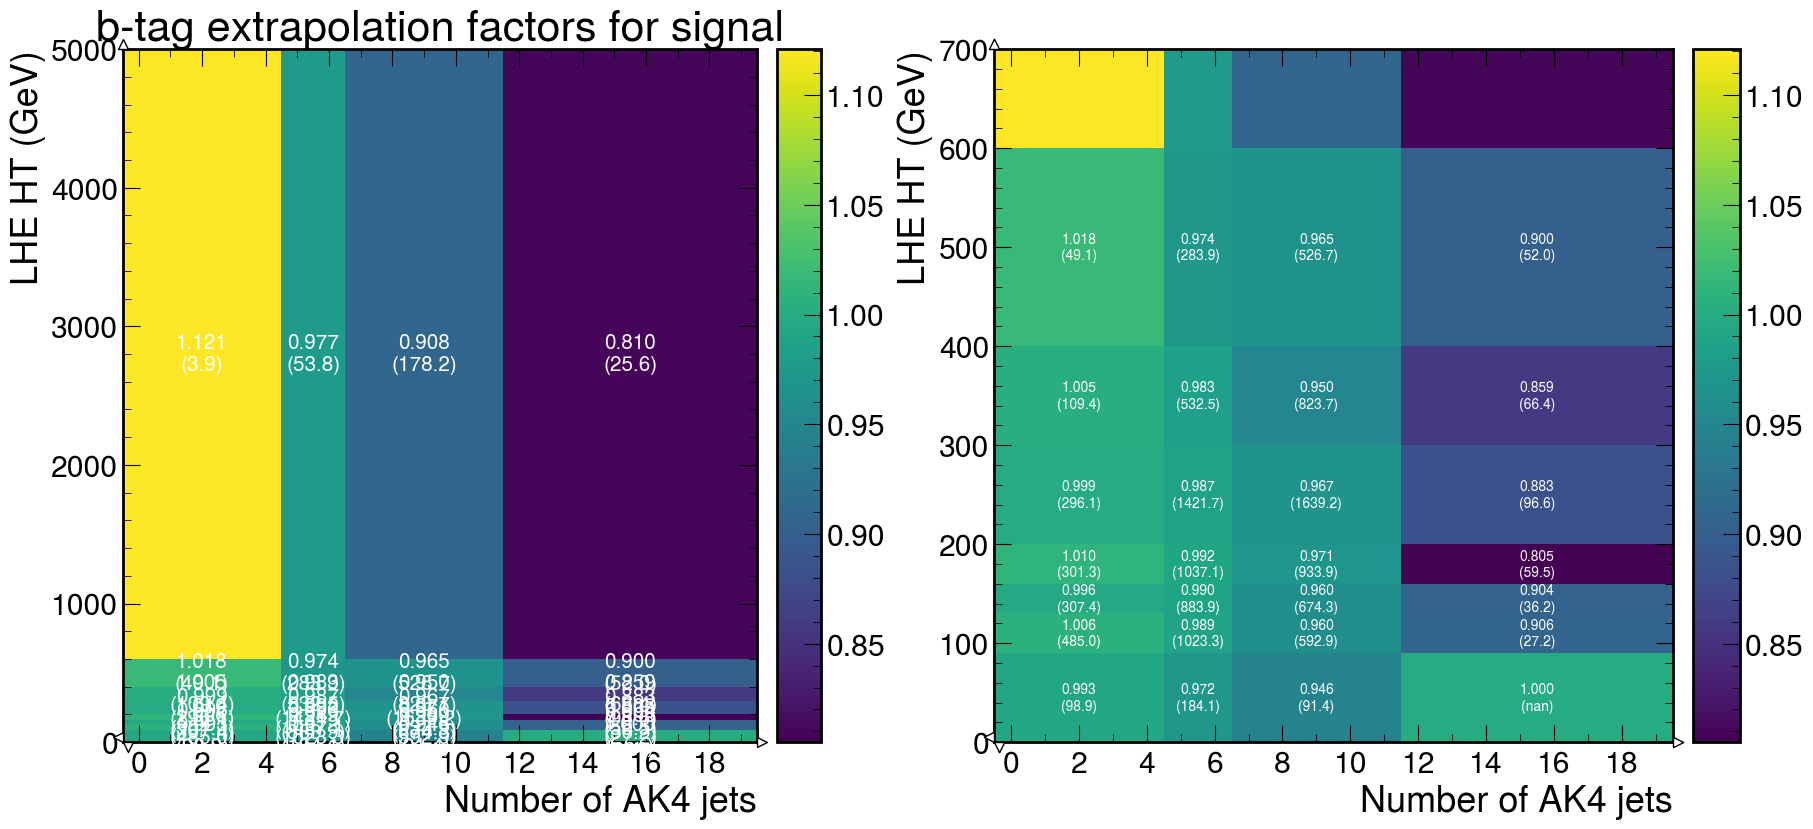

In [78]:
# ZH
mass = 0
flow = True
rebin_x, rebin_y = get_rebin_signal_ztthbb(mass)
plot_factors(make_extrap_factor_hist(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], *make_extrap_factor(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow), h_rebinned=h_nobtag_ztthbb_signal[mass][::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)], text=True, ylim_intermediate=700)

rebin_x, rebin_y = get_rebin_signal_zbbhtt(mass)
plot_factors(make_extrap_factor_hist(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], *make_extrap_factor(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow), h_rebinned=h_nobtag_zbbhtt_signal[mass][::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)], text=True, ylim_intermediate=700)


/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'
/tmp/ipykernel_619463/845168294.py:18: RuntimeWarning: invalid value encountered in scalar divide
  return f'\n({np.square(v.value)/v.variance:.1f})'


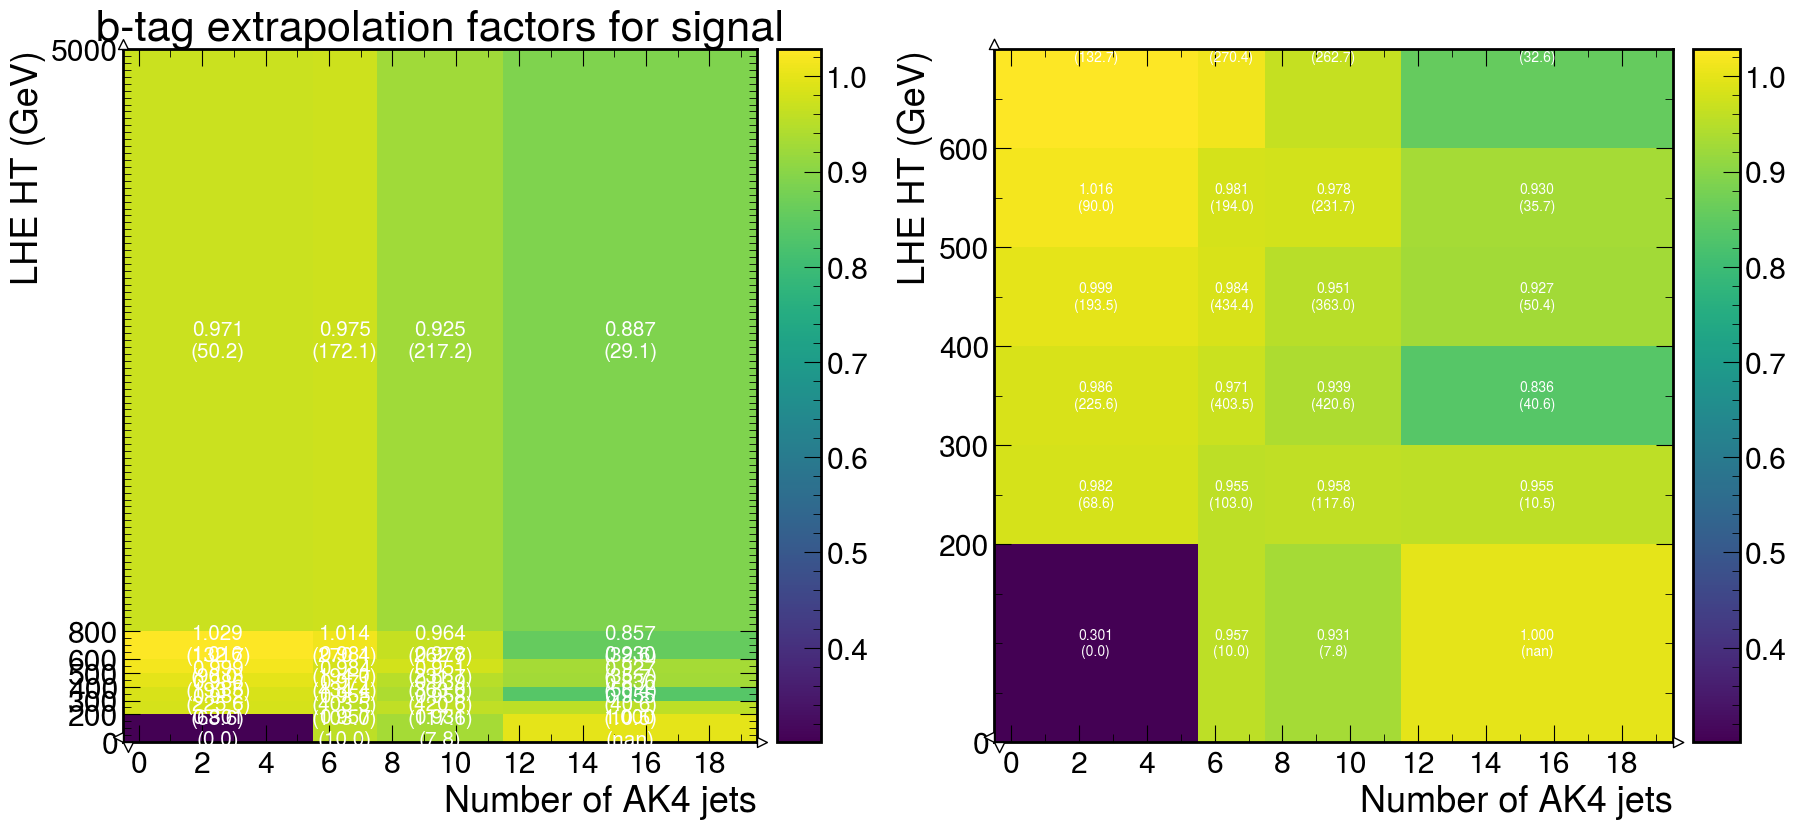

In [79]:
# ZZ
mass = 1500
flow = True
rebin_x, rebin_y = get_rebin_signal_zz(mass)
plot_factors(make_extrap_factor_hist(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], *make_extrap_factor(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow),h_rebinned=h_nobtag_zz_signal[mass][::copy.deepcopy(rebin_x), ::copy.deepcopy(rebin_y)], text=True, ylim_intermediate=700)

In [80]:
flow = True
h_extrap_factor_zz_signal = {}
for mass in [0] + resonant_masses_ZZ:
    rebin_x, rebin_y = get_rebin_signal_zz(mass)
    
    h_extrap_factor_zz_signal[mass] = make_extrap_factor_hist(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], *make_extrap_factor(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
h_extrap_factor_zbbhtt_signal = {}
h_extrap_factor_ztthbb_signal = {}
for mass in [0] + resonant_masses_ZH:
    rebin_x, rebin_y = get_rebin_signal_zbbhtt(mass)
    h_extrap_factor_zbbhtt_signal[mass] = make_extrap_factor_hist(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], *make_extrap_factor(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)

    rebin_x, rebin_y = get_rebin_signal_ztthbb(mass)
    h_extrap_factor_ztthbb_signal[mass] = make_extrap_factor_hist(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], *make_extrap_factor(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)

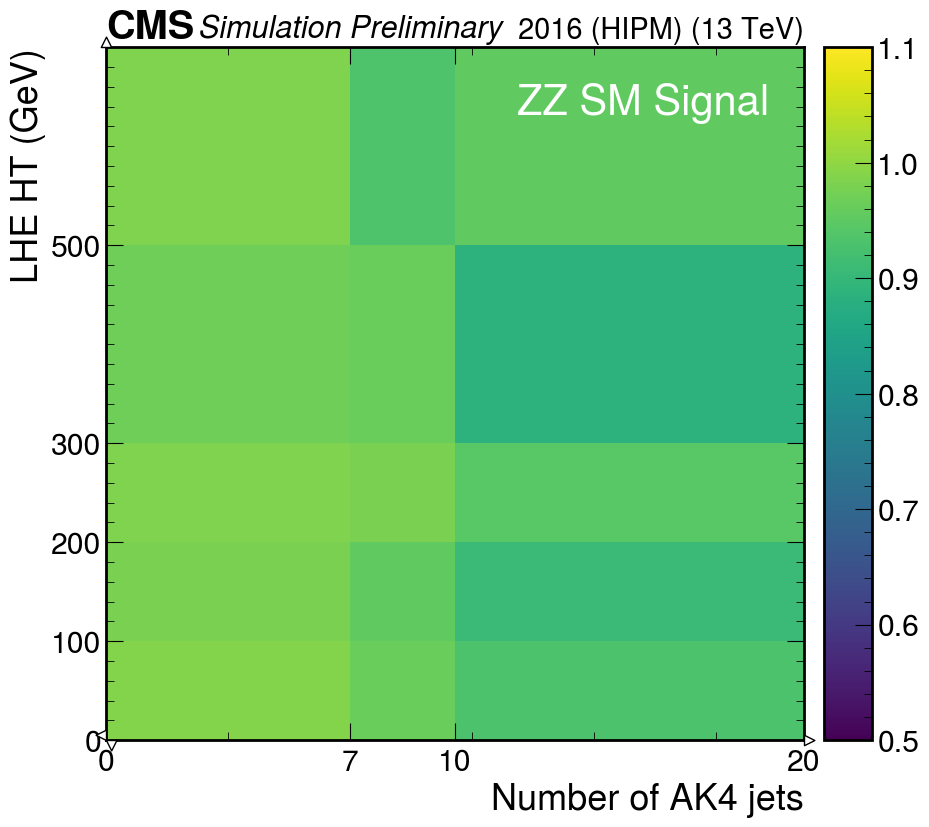

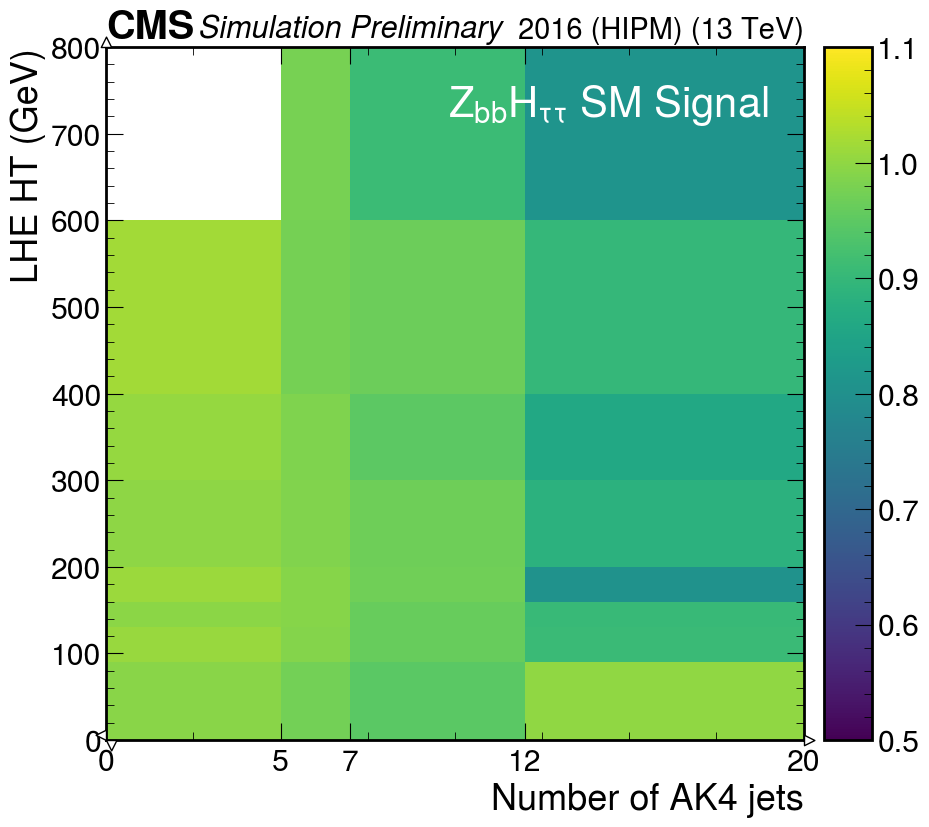

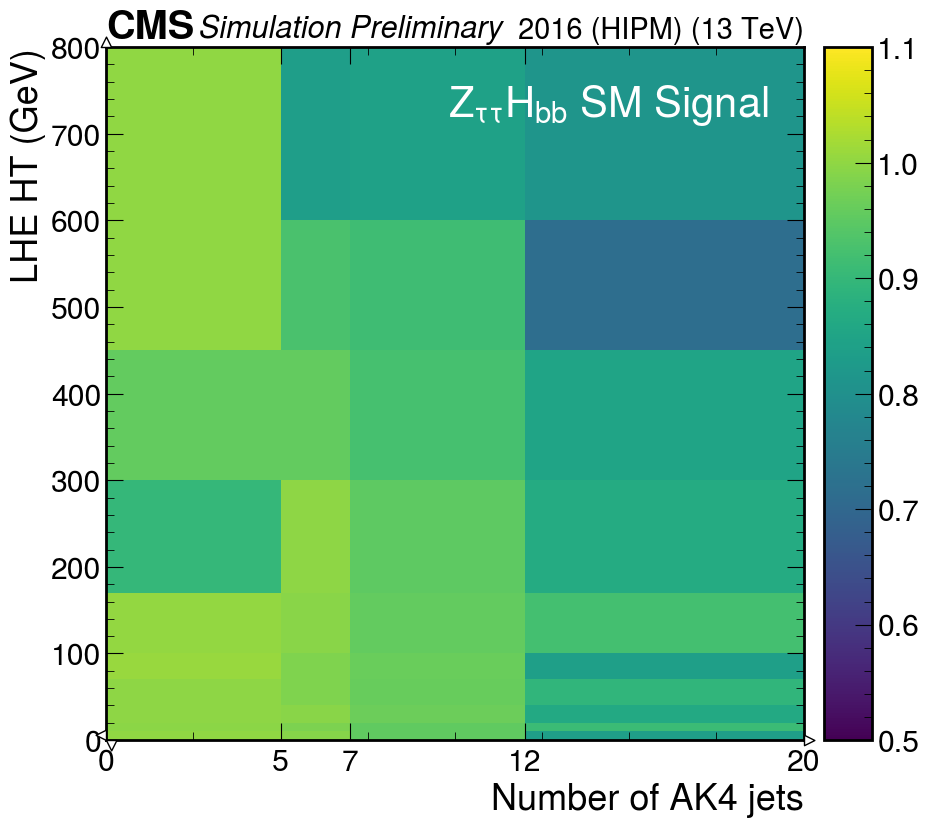

In [81]:
# Nice plots for AN
flow=True
mass=0
histplot_kwargs = dict(cmin=0.5, cmax=1.1)

rebin_x, rebin_y = get_rebin_signal_zz(mass)
h_extrap_factor = make_extrap_factor_hist(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], *make_extrap_factor(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
fig, ax = plt.subplots(figsize=(9, 9))
hep.hist2dplot(h_extrap_factor, ax=ax, **histplot_kwargs)
ax.set_ylabel("LHE HT (GeV)")
ax.set_xlabel("Number of AK4 jets")
#ax.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# plt.yscale("log")
hep.cms.label(year="2016 (HIPM)" if year == "2016_HIPM" else year, data=False, label="Preliminary", ax=ax, fontsize=22)
ax.text(0.95, 0.95, "ZZ SM Signal", transform=ax.transAxes, ha="right", va="top", color="white", fontsize=30)
ax.set_ylim(0, 700)
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/zz_sl_signal_{year}.pdf", bbox_inches="tight")


rebin_x, rebin_y = get_rebin_signal_zbbhtt(mass)
h_extrap_factor = make_extrap_factor_hist(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], *make_extrap_factor(h_nobtag_zbbhtt_signal[mass], h_btag_zbbhtt_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
fig, ax = plt.subplots(figsize=(9, 9))
hep.hist2dplot(h_extrap_factor, ax=ax, **histplot_kwargs)
ax.set_ylabel("LHE HT (GeV)")
ax.set_xlabel("Number of AK4 jets")
#ax.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# plt.yscale("log")
hep.cms.label(year="2016 (HIPM)" if year == "2016_HIPM" else year, data=False, label="Preliminary", ax=ax, fontsize=22)
ax.text(0.95, 0.95, r"$Z_{bb}H_{\tau\tau}$ SM Signal", transform=ax.transAxes, ha="right", va="top", color="white", fontsize=30)
ax.set_ylim(0, 800)
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/zbb_htt_signal_{year}.pdf", bbox_inches="tight")

rebin_x, rebin_y = get_rebin_signal_ztthbb(mass)
h_extrap_factor = make_extrap_factor_hist(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], *make_extrap_factor(h_nobtag_ztthbb_signal[mass], h_btag_ztthbb_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
fig, ax = plt.subplots(figsize=(9, 9))
hep.hist2dplot(h_extrap_factor, ax=ax, **histplot_kwargs)
ax.set_ylabel("LHE HT (GeV)")
ax.set_xlabel("Number of AK4 jets")
#ax.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# plt.yscale("log")
hep.cms.label(year="2016 (HIPM)" if year == "2016_HIPM" else year, data=False, label="Preliminary", ax=ax, fontsize=22)
ax.text(0.95, 0.95, r"$Z_{\tau\tau}H_{bb}$ SM Signal", transform=ax.transAxes, ha="right", va="top", color="white", fontsize=30)
ax.set_ylim(0, 800)
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/ztt_hbb_signal_{year}.pdf", bbox_inches="tight")

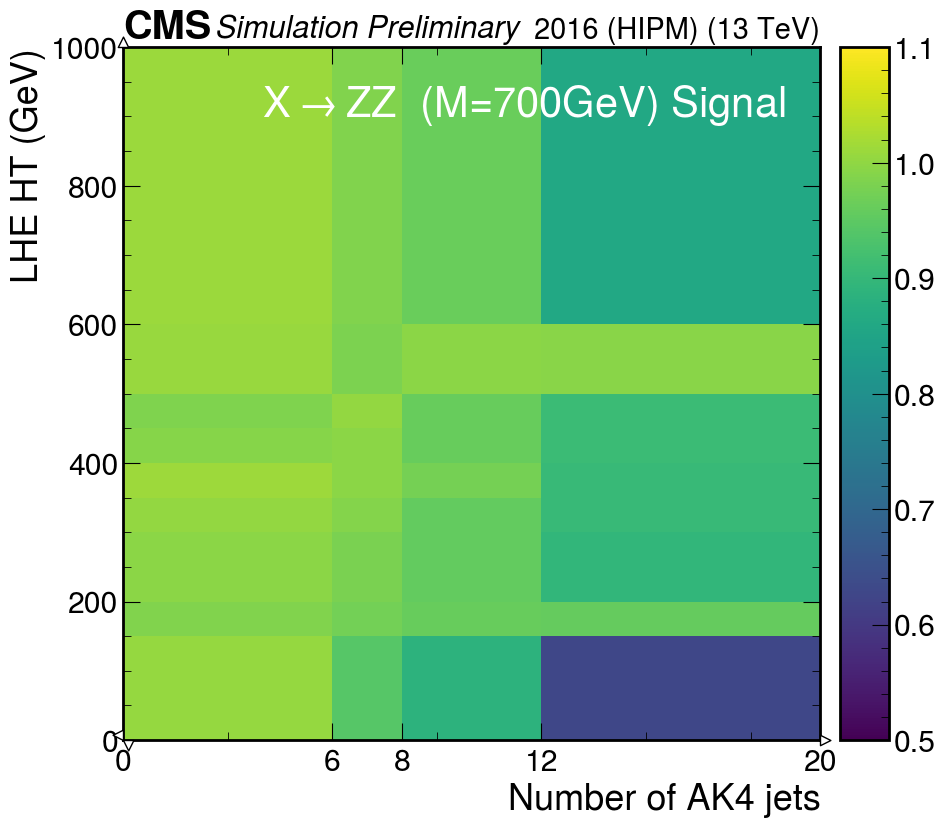

In [82]:
# nice plots resonant
histplot_kwargs = dict(cmin=0.5, cmax=1.1)
mass = 700

rebin_x, rebin_y = get_rebin_signal_zz(mass)
h_extrap_factor = make_extrap_factor_hist(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], *make_extrap_factor(h_nobtag_zz_signal[mass], h_btag_zz_signal[mass], rebin_x, rebin_y, flow), rebin_x, rebin_y, flow)
fig, ax = plt.subplots(figsize=(9, 9))
hep.hist2dplot(h_extrap_factor, ax=ax, **histplot_kwargs)
ax.set_ylabel("LHE HT (GeV)")
ax.set_xlabel("Number of AK4 jets")
#ax.set_xticks([i+0.5 for i in range(0, 20, 2)], [str(i) for i in range(0, 20, 2)])
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
# plt.yscale("log")
hep.cms.label(year="2016 (HIPM)" if year == "2016_HIPM" else year, data=False, label="Preliminary", ax=ax, fontsize=22)
ax.text(0.95, 0.95, r"$X\to ZZ$ " f" (M={mass}GeV) Signal", transform=ax.transAxes, ha="right", va="top", color="white", fontsize=30)
ax.set_ylim(0, 1000)
plt.savefig(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag/ggXZZbbtt_M{mass}_{year}.pdf", bbox_inches="tight")


# Saving to correctionlib

In [83]:
corrections = []
import copy
def clamp_histo(h):
    new_h = hist.Hist(h)
    new_h.view(True).value = np.clip(h.view(True).value, 0.4, 1.6)
    return new_h

for process, h_extrap in h_extrap_factors_bkgs.items():
    h_extrap.name = f"extrap_factor_{process}"
    h_extrap.label="Extrapolation factor to multiply to event weight"
    if np.max(h_extrap.values(flow=False))>1.4 or np.min(h_extrap.values(flow=False))<0.5: print(f"##WARNING {process}")
    corrections.append(correctionlib.convert.from_histogram(clamp_histo(h_extrap), flow="clamp"))

for mass, h_extrap in h_extrap_factor_zz_signal.items():
    if mass == 0: h_extrap.name = "extrap_factor_zz_sl_signal"
    else: h_extrap.name = f"extrap_factor_ggXZZbbtt_M{mass}"
    h_extrap.label="Extrapolation factor to multiply to event weight"
    if np.max(h_extrap.values(flow=False))>1.4 or np.min(h_extrap.values(flow=False))<0.5: print(f"##WARNING ggXZZbbtt_M{mass}")
    corrections.append(correctionlib.convert.from_histogram(clamp_histo(h_extrap), flow="clamp"))
for mass, h_extrap in h_extrap_factor_zbbhtt_signal.items():
    if mass == 0: h_extrap.name = "zh_zbb_htt_signal"
    else: h_extrap.name = f"extrap_factor_Zprime_Zh_Zbbhtautau_M{mass}"
    h_extrap.label="Extrapolation factor to multiply to event weight"
    if np.max(h_extrap.values(flow=False))>1.4 or np.min(h_extrap.values(flow=False))<0.5: print(f"##WARNING Zprime_Zh_Zbbhtautau_M{mass}")
    corrections.append(correctionlib.convert.from_histogram(clamp_histo(h_extrap), flow="clamp"))
for mass, h_extrap in h_extrap_factor_ztthbb_signal.items():
    if mass == 0: h_extrap.name = "zh_ztt_hbb_signal"
    else: h_extrap.name = f"extrap_factor_Zprime_Zh_Ztautauhbb_M{mass}"
    h_extrap.label="Extrapolation factor to multiply to event weight"
    if np.max(h_extrap.values(flow=False))>1.4 or np.min(h_extrap.values(flow=False))<0.5: print(f"##WARNING Zprime_Zh_Ztautauhbb_M{mass}")
    corrections.append(correctionlib.convert.from_histogram(clamp_histo(h_extrap), flow="clamp"))

cset = correctionlib.schemav2.CorrectionSet(
    schema_version=2,
    description=f"b-tag extrapolation factors for {year}",
    corrections=corrections,
)

##WARNING tt
##WARNING dy
##WARNING wjets
##WARNING others
##WARNING ggXZZbbtt_M1500


In [84]:
with open(f"/grid_mnt/data__data.polcms/cms/cuisset/ZHbbtautau/framework/studies/SFs/btag-extrap-{year}-v7.json", "w") as fout:
    fout.write(cset.json(exclude_unset=True))